#Libraries

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.metrics import Precision, Recall

In [12]:
# Import packages
import os
import cv2
import imutils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, roc_auc_score

#Setup datasets

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the dataset
IMG_PATH = '/content/drive/MyDrive/brain_tumor_dataset/'

# Create a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):

         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')


Mounted at /content/drive
Train set size: 183
Validation set size: 62
Test set size: 8


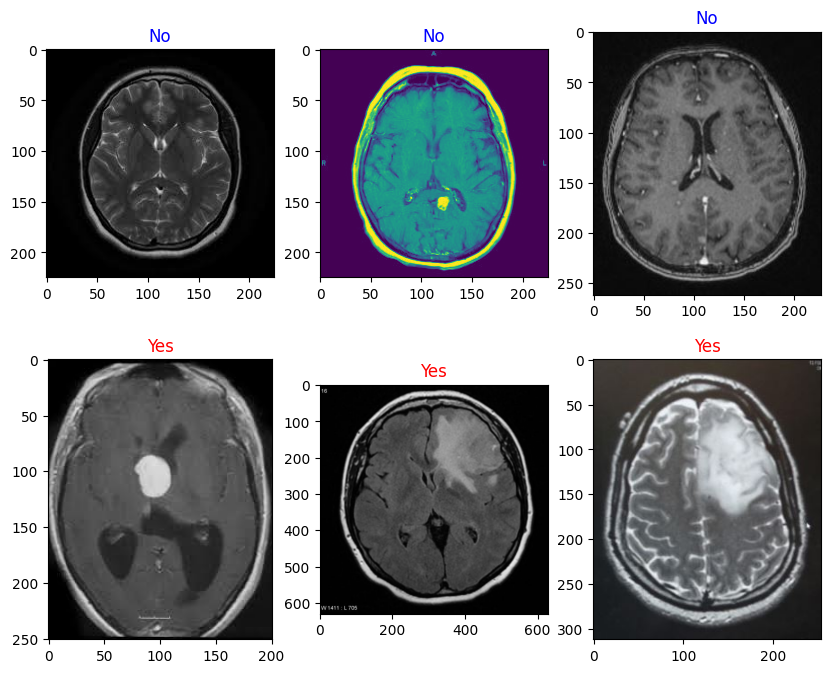

In [4]:

%matplotlib inline

# Define the labels and their corresponding colors
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:3]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

#Data pre-processing

In [5]:
def preprocess_images(images):
    preprocessed_images = []
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        preprocessed_images.append(new_img)
    return np.array(preprocessed_images)

In [6]:
# Apply the preprocessing to all the data subsets
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

In [7]:
# Transform the subsets to numpy arrays
X_train_pre = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre = np.array([preprocess_input(image) for image in X_test_pre])

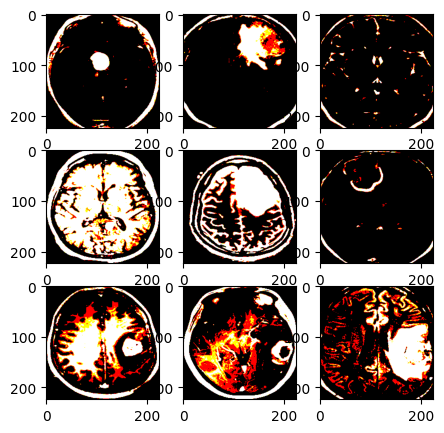

In [8]:
# plot some images from X_train_pre
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre[i], cmap='gray')
plt.show()

#Train Model

In [16]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Convert labels to numpy array for fitting
import numpy as np
y_train = np.array(y_train)
y_val = np.array(y_val)

# Train the model
history = model.fit(x=np.array(X_train_pre),
                    y=np.array(y_train),
                    epochs=10,
                    batch_size=32,
                    validation_data=(np.array(X_val_pre), np.array(y_val)),
                    verbose=1)


# Save the model
model.save('/content/drive/MyDrive/brain_tumor_classifier.h5')

Epoch 1/10
6/6 [==============================] - 59s 10s/step - loss: 2.3624 - accuracy: 0.6175 - precision: 0.7273 - recall: 0.6261 - val_loss: 0.4556 - val_accuracy: 0.8387 - val_precision: 0.7917 - val_recall: 1.0000
Epoch 2/10
6/6 [==============================] - 52s 9s/step - loss: 0.7973 - accuracy: 0.7650 - precision: 0.7338 - recall: 0.9826 - val_loss: 0.4825 - val_accuracy: 0.8387 - val_precision: 1.0000 - val_recall: 0.7368
Epoch 3/10
6/6 [==============================] - 56s 9s/step - loss: 0.4029 - accuracy: 0.8361 - precision: 0.9775 - recall: 0.7565 - val_loss: 0.1911 - val_accuracy: 0.9032 - val_precision: 0.9000 - val_recall: 0.9474
Epoch 4/10
6/6 [==============================] - 44s 7s/step - loss: 0.3927 - accuracy: 0.8361 - precision: 0.8102 - recall: 0.9652 - val_loss: 0.2122 - val_accuracy: 0.9194 - val_precision: 0.9024 - val_recall: 0.9737
Epoch 5/10
6/6 [==============================] - 44s 7s/step - loss: 0.1890 - accuracy: 0.9180 - precision: 0.9808 - r

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Evaluation

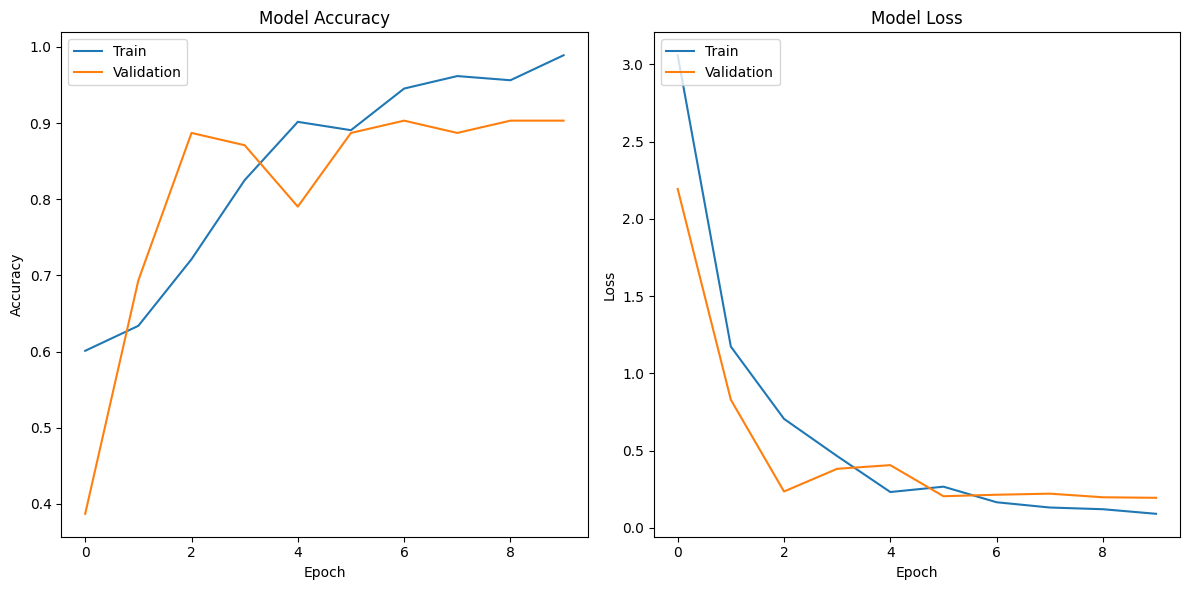

1/1 [==============================] - 1s 1s/step - loss: 0.2361 - accuracy: 0.8750
Test Accuracy: 0.875
Test Loss: 0.236136794090271
1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

    No Tumor       1.00      0.83      0.91         6
       Tumor       0.67      1.00      0.80         2

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8

ROC-AUC Score: 1.0


In [13]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(np.array(X_test_pre), np.array(y_test))
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

# Make predictions
y_pred = model.predict(np.array(X_test_pre))
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred_binary, target_names=['No Tumor', 'Tumor'])
print(report)

# Calculate the ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC Score: {roc_auc}')

In [19]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned from model.fit()
validation_loss = history.history['val_loss'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

print(f"Final Validation Loss: {validation_loss:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy:.2f}")


print(f"Final Validation Precision: {val_precision:.2f}")
print(f"Final Validation Recall: {val_recall:.2f}")
print(f"Final Validation F1-Score: {val_f1_score:.2f}")

# Predict probabilities for the validation set
val_probs = model.predict(np.array(X_val_pre))

val_auc = roc_auc_score(np.array(y_val), val_probs)
print(f"Validation AUC: {val_auc:.2f}")

Final Validation Loss: 0.2077
Final Validation Accuracy: 0.87
Final Validation Precision: 0.88
Final Validation Recall: 0.92
Final Validation F1-Score: 0.90
2/2 [==============================] - 14s 6s/step
Validation AUC: 0.97


1/1 [==============================] - 2s 2s/step


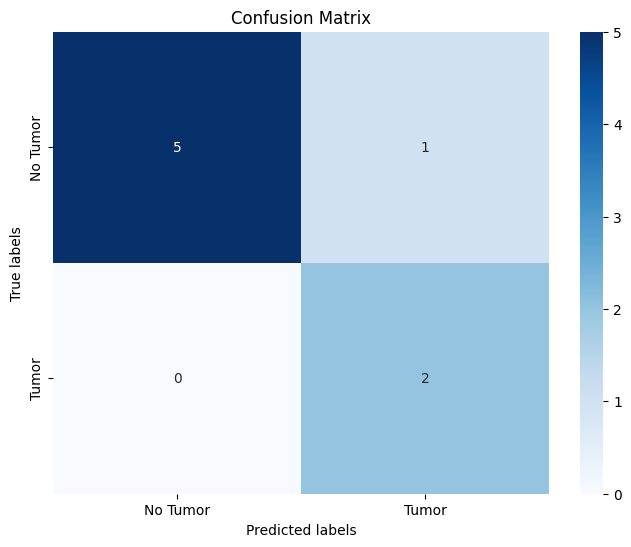

              precision    recall  f1-score   support

    No Tumor       1.00      0.83      0.91         6
       Tumor       0.67      1.00      0.80         2

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



In [20]:
# Predict the labels on the test set
predictions = model.predict(np.array(X_test_pre))
# Convert probabilities to binary predictions (0 or 1)
predictions = (predictions > 0.5).astype(int)

# Get the confusion matrix
cm = confusion_matrix(np.array(y_test), predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally print the classification report
print(classification_report(np.array(y_test), predictions, target_names=['No Tumor', 'Tumor']))